In [1]:
# Alpamayo-R1 on YOUR workzone videos (state classification)

import os, sys, re, random, time
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import torch

os.environ["TOKENIZERS_PARALLELISM"] = "false"

ROOT = Path("..").resolve()          # you run from <root>/notebooks
DATA_DIR = ROOT / "data"
VIDEOS_DIR = DATA_DIR / "videos_compressed"

print("ROOT:", ROOT)
print("VIDEOS_DIR exists:", VIDEOS_DIR.exists(), VIDEOS_DIR)


ROOT: /data/wesleyferreiramaia/workzone
VIDEOS_DIR exists: True /data/wesleyferreiramaia/workzone/data/videos_compressed


In [2]:
# If your repo has src/ with alpamayo_r1 inside, keep this:
if os.path.abspath("src") not in sys.path:
    sys.path.append(os.path.abspath("src"))

from alpamayo_r1.models.alpamayo_r1 import AlpamayoR1
from alpamayo_r1.load_physical_aiavdataset import load_physical_aiavdataset
from alpamayo_r1 import helper

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16 if DEVICE == "cuda" else torch.float16

MODEL_ID = "nvidia/Alpamayo-R1-10B"

print("DEVICE:", DEVICE, "| DTYPE:", DTYPE)

print("Loading model...")
model = AlpamayoR1.from_pretrained(MODEL_ID, dtype=DTYPE).to(DEVICE)
model.eval()

processor = helper.get_processor(model.tokenizer)
print("Model + processor loaded.")

DEVICE: cuda | DTYPE: torch.bfloat16
Loading model...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Model + processor loaded.


In [5]:
# Any valid clip_id you already used successfully:
TEMPLATE_CLIP_ID = "030c760c-ae38-49aa-9ad8-f5650a545d26"

print("Loading template data to steal shapes...")
tmpl = load_physical_aiavdataset(TEMPLATE_CLIP_ID, t0_us=5_100_000)

print("Template keys:", tmpl.keys())
print("image_frames:", tmpl["image_frames"].shape, tmpl["image_frames"].dtype)
print("ego_history_xyz:", tmpl["ego_history_xyz"].shape, tmpl["ego_history_xyz"].dtype)
print("ego_history_rot:", tmpl["ego_history_rot"].shape, tmpl["ego_history_rot"].dtype)
print("ego_future_xyz:", tmpl["ego_future_xyz"].shape)

Loading template data to steal shapes...
Template keys: dict_keys(['image_frames', 'camera_indices', 'ego_history_xyz', 'ego_history_rot', 'ego_future_xyz', 'ego_future_rot', 'relative_timestamps', 'absolute_timestamps', 't0_us', 'clip_id'])
image_frames: torch.Size([4, 4, 3, 1080, 1920]) torch.uint8
ego_history_xyz: torch.Size([1, 1, 16, 3]) torch.float32
ego_history_rot: torch.Size([1, 1, 16, 3, 3]) torch.float32
ego_future_xyz: torch.Size([1, 1, 64, 3])


In [6]:
import cv2
import torch
import numpy as np
import re
import textwrap
from pathlib import Path

# --- 1. Robust Text Cleaner ---
def clean_and_wrap_text(raw_text, width=60):
    # Unwrap nested lists recursively (handles [['Text']] or even [[['Text']]])
    while isinstance(raw_text, list):
        if len(raw_text) > 0: raw_text = raw_text[0]
        else: raw_text = ""
            
    if hasattr(raw_text, 'decode'): 
        raw_text = raw_text.decode("utf-8", "ignore")
        
    text = str(raw_text)
    
    # Remove special tokens and prompt echoes
    text = text.replace("<|im_start|>", "").replace("<|im_end|>", "").strip()
    if "assistant" in text:
        text = text.split("assistant")[-1]
        
    text = text.replace("Output the chain-of-thought", "").replace("future trajectory.", "")
    text = text.strip()
    
    # Wrap text into multiple lines for the video
    lines = textwrap.wrap(text, width=width)
    return lines, text

# --- 2. Main Loop ---
def run_final_visualization(video_path, model, processor, tmpl, out_path, stride=3):
    video_path = Path(video_path)
    cap = cv2.VideoCapture(str(video_path))
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    
    out = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))
    T1, T2, C, tH, tW = tmpl["image_frames"].shape
    
    # "Cruise Control" History (Neutralizing the Ghost Driver)
    cruise_xyz = torch.zeros_like(tmpl["ego_history_xyz"])
    cruise_rot = torch.zeros_like(tmpl["ego_history_rot"])
    cruise_rot[..., 0] = 1.0
    for i in range(cruise_xyz.shape[1]):
        cruise_xyz[0, i, 0] = 10.0 * ((i - 20) * 0.1)

    print(f"Processing: {video_path.name}")

    try:
        while True:
            frames_bgr = []
            sampled_rgb = []
            for i in range(int(T1*T2) * stride):
                ret, frame = cap.read()
                if not ret: break
                frames_bgr.append(frame)
                if i % stride == 0:
                    fr = cv2.resize(frame, (tW, tH))
                    fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
                    sampled_rgb.append(fr)
            
            if len(sampled_rgb) != int(T1*T2): break 

            tensor = torch.from_numpy(np.stack(sampled_rgb))
            tensor = tensor.permute(0, 3, 1, 2).unsqueeze(0)
            
            # --- Native Prompt ---
            messages = helper.create_message(tensor[0])
            instruction_text = "Output the chain-of-thought reasoning of the driving process, then output the future trajectory."
            
            if isinstance(messages[0]["content"], list):
                messages[0]["content"].append({"type": "text", "text": instruction_text})
            else:
                messages[0]["content"] = instruction_text

            inputs = processor.apply_chat_template(
                messages, 
                tokenize=True, 
                add_generation_prompt=True,
                return_dict=True, 
                return_tensors="pt",
            )
            
            model_inputs = {
                "tokenized_data": inputs,
                "ego_history_xyz": cruise_xyz, 
                "ego_history_rot": cruise_rot,
            }
            model_inputs = helper.to_device(model_inputs, "cuda")

            # Inference
            with torch.autocast("cuda", dtype=torch.bfloat16):
                _, _, extra = model.sample_trajectories_from_data_with_vlm_rollout(
                    data=model_inputs,
                    top_p=0.8, 
                    temperature=0.6, 
                    num_traj_samples=1,
                    max_generation_length=256,
                    return_extra=True,
                )

            # --- Clean Data for Display ---
            raw_output = extra.get("cot", [""])[0]
            lines, full_text = clean_and_wrap_text(raw_output, width=65)
            
            # Print FULL text to console (No cutting!)
            print(f"Thought: {full_text}")

            # Draw on Video
            for fr in frames_bgr:
                # Black banner at the top
                banner_height = 50 + (len(lines) * 35)
                cv2.rectangle(fr, (0, 0), (W, banner_height), (0, 0, 0), -1)
                
                # Title
                cv2.putText(fr, "ALPAYMAO REASONING:", (20, 35), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
                
                # Draw lines
                y = 80
                for line in lines:
                    cv2.putText(fr, line, (20, y), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                    y += 35
                
                out.write(fr)

    finally:
        cap.release()
        out.release()
        print(f"Saved: {out_path}")

run_final_visualization(
    video_path=Path("/home/wesleyferreiramaia/data/workzone/data/demo/san_antonio.mp4"),
    model=model,
    processor=processor,
    tmpl=tmpl,
    out_path=Path("alpamayo_result.mp4"),
)

Processing: san_antonio.mp4
Thought: [['Keep lane to continue driving since the lane ahead is clear.']]
Thought: [['Keep lane to continue driving since no critical agent needs attention.']]
Thought: [['Slow down to stop at the stop sign ahead.']]
Thought: [['Stop for the stop sign at the intersection.']]
Thought: [['Nudge to the left to increase clearance from the construction equipment on the right.']]
Thought: [['Nudge to the left to increase clearance from the construction worker on the right.']]
Thought: [['Nudge left to increase clearance from the construction worker on the right.']]
Thought: [['Nudge to the left to increase clearance from the construction cones intruding into the lane.']]
Thought: [['Nudge to the left to avoid the cone in the same lane.']]
Saved: alpamayo_result.mp4


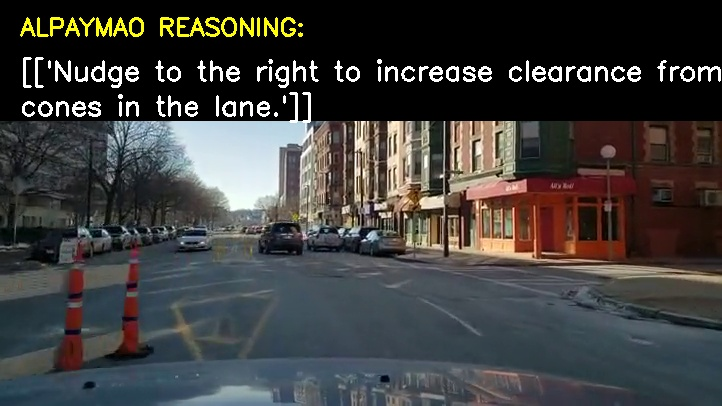

Thought: [['Nudge to the right to increase clearance from the construction cones in the lane.']]
Saved full video to: alpamayo_live.mp4


In [7]:
import cv2
import torch
import numpy as np
import re
import textwrap
from pathlib import Path
from IPython.display import display, Image, clear_output  # <--- NEW IMPORT

# --- 1. Robust Text Cleaner ---
def clean_and_wrap_text(raw_text, width=60):
    while isinstance(raw_text, list):
        if len(raw_text) > 0: raw_text = raw_text[0]
        else: raw_text = ""
            
    if hasattr(raw_text, 'decode'): 
        raw_text = raw_text.decode("utf-8", "ignore")
        
    text = str(raw_text)
    text = text.replace("<|im_start|>", "").replace("<|im_end|>", "").strip()
    if "assistant" in text:
        text = text.split("assistant")[-1]
        
    text = text.replace("Output the chain-of-thought", "").replace("future trajectory.", "")
    text = text.strip()
    lines = textwrap.wrap(text, width=width)
    return lines, text

# --- 2. Main Loop (With Live Display) ---
def run_live_inference(video_path, model, processor, tmpl, out_path, stride=3):
    video_path = Path(video_path)
    cap = cv2.VideoCapture(str(video_path))
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    
    out = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*"mp4v"), fps, (W, H))
    T1, T2, C, tH, tW = tmpl["image_frames"].shape
    
    # "Cruise Control" History
    cruise_xyz = torch.zeros_like(tmpl["ego_history_xyz"])
    cruise_rot = torch.zeros_like(tmpl["ego_history_rot"])
    cruise_rot[..., 0] = 1.0
    for i in range(cruise_xyz.shape[1]):
        cruise_xyz[0, i, 0] = 10.0 * ((i - 20) * 0.1)

    print(f"Processing: {video_path.name}")
    print("Starting Live View...")

    try:
        while True:
            frames_bgr = []
            sampled_rgb = []
            for i in range(int(T1*T2) * stride):
                ret, frame = cap.read()
                if not ret: break
                frames_bgr.append(frame)
                if i % stride == 0:
                    fr = cv2.resize(frame, (tW, tH))
                    fr = cv2.cvtColor(fr, cv2.COLOR_BGR2RGB)
                    sampled_rgb.append(fr)
            
            if len(sampled_rgb) != int(T1*T2): break 

            tensor = torch.from_numpy(np.stack(sampled_rgb))
            tensor = tensor.permute(0, 3, 1, 2).unsqueeze(0)
            
            # --- Prompt ---
            messages = helper.create_message(tensor[0])
            instruction_text = "Output the chain-of-thought reasoning of the driving process, then output the future trajectory."
            
            if isinstance(messages[0]["content"], list):
                messages[0]["content"].append({"type": "text", "text": instruction_text})
            else:
                messages[0]["content"] = instruction_text

            inputs = processor.apply_chat_template(
                messages, 
                tokenize=True, 
                add_generation_prompt=True,
                return_dict=True, 
                return_tensors="pt",
            )
            
            model_inputs = {
                "tokenized_data": inputs,
                "ego_history_xyz": cruise_xyz, 
                "ego_history_rot": cruise_rot,
            }
            model_inputs = helper.to_device(model_inputs, "cuda")

            # Inference
            with torch.autocast("cuda", dtype=torch.bfloat16):
                _, _, extra = model.sample_trajectories_from_data_with_vlm_rollout(
                    data=model_inputs,
                    top_p=0.8, 
                    temperature=0.6, 
                    num_traj_samples=1,
                    max_generation_length=256,
                    return_extra=True,
                )

            # --- Clean Data ---
            raw_output = extra.get("cot", [""])[0]
            lines, full_text = clean_and_wrap_text(raw_output, width=65)
            
            # Draw on Video
            for fr in frames_bgr:
                banner_height = 50 + (len(lines) * 35)
                cv2.rectangle(fr, (0, 0), (W, banner_height), (0, 0, 0), -1)
                cv2.putText(fr, "ALPAYMAO REASONING:", (20, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
                
                y = 80
                for line in lines:
                    cv2.putText(fr, line, (20, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
                    y += 35
                
                out.write(fr)

            # --- LIVE DISPLAY LOGIC ---
            # We take the LAST frame of the batch to show the current state
            # Encode frame to JPG
            _, encoded_img = cv2.imencode('.jpg', frames_bgr[-1]) 
            
            # Clear previous output to create animation effect
            clear_output(wait=True)
            
            # Display image in the notebook
            display(Image(data=encoded_img))
            
            # Print the text below the image for readability
            print(f"Thought: {full_text}")

    finally:
        cap.release()
        out.release()
        print(f"Saved full video to: {out_path}")

# Run
run_live_inference(
    video_path=Path("/home/wesleyferreiramaia/data/workzone/data/demo/boston_workzone_short.mp4"),
    model=model,
    processor=processor,
    tmpl=tmpl,
    out_path=Path("alpamayo_live.mp4"),
)